In [1]:
# Insert code here.
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint
dtype=torch.float
import torch.nn as nn

%matplotlib inline


In [2]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

0
1
Tesla P100-PCIE-16GB
True


In [3]:
# for the plots
plt.rc('xtick', labelsize=16) 
plt.rcParams.update({'font.size': 16})

# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

In [4]:
# Define some more general functions
def dfx(x,f):
    # Calculate the derivative with auto-differention
    gopts = torch.ones(x.shape, dtype=dtype, device = torch.device('cuda:0'))
    return grad([f], [x], grad_outputs=gopts, create_graph=True)[0]

def perturbPoints(grid,t0,tf,sig=0.5):
#   stochastic perturbation of the evaluation points
#   force t[0]=t0  & force points to be in the t-interval
    delta_t = grid[1] - grid[0]  
    noise = delta_t * torch.randn_like(grid)*sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0]=t0 - t.data[t<t0]
    t.data[t>tf]=2*tf - t.data[t>tf]
    t.data[0] = torch.ones(1,1)*t0

    t.data[-1] = torch.ones(1,1)*tf
    t.requires_grad = False
    return t

In [5]:
def parametricSolutions(t, nn, t0, x1, endpoint):
    # parametric solutions 
    N1,N2 = nn(t)
    
    #### THERE ARE TWO PARAMETRIC SOLUTIONS.
    f = (1-torch.exp(t-endpoint))

    psi_hat  = f*N1
    return psi_hat


def hamEqs_Loss(t,psi, E,V):
    psi_dx = dfx(t,psi)
    psi_ddx= dfx(t,psi_dx)
    f = psi_ddx + psi_dx*2/t + (2*E+V)*psi
    L  = (f.pow(2)).mean(); 
    var_loss = (f.pow(2)).var()
    H_psi = -1*psi_ddx/2 + (V)*psi
    return L, f, H_psi, var_loss

In [1]:
class qNN1(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(qNN1,self).__init__()

        # Define the Activation
        self.actF = mySin()
        
        # define layers
        self.Ein    = torch.nn.Linear(1,1)
        self.Lin_1  = torch.nn.Linear(2, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)#torch.nn.Linear(D_hid+1, D_hid)
        self.out    = torch.nn.Linear(D_hid, 1)#torch.nn.Linear(D_hid+1, 1)

    def forward(self,t):
        In1 = self.Ein(torch.ones_like(t))#torch.ones_like(t)/-18#

        L1 = self.Lin_1(torch.cat((t,In1),1))
        #L1p = self.Lin_1(torch.cat((-1*t,In1),1))

        h1 = self.actF(L1)
        #h1p = self.actF(L1p)
        
        L2 = self.Lin_2(h1)#self.Lin_2(torch.cat((h1,In1),1))
        #L2p = self.Lin_2(torch.cat((h1p,In1),1))

        h2 = self.actF(L2)
        #h2p = self.actF(L2p)

        out = self.out(h2)#self.out(torch.cat((h2, In1),1))#self.out(torch.cat((h2+h2p,In1),1))#
        return out, -torch.abs(In1)

NameError: ignored

In [7]:
def potential(Xs):
  # Gives the potential at each point
  # Takes in tensor of x points, gives back tensor of V at each point

  l = 0
  Xsnp = Xs.data.numpy()
  Vnp = 2/Xsnp-l*(l+1)/Xsnp**2
  Vtorch = torch.from_numpy(Vnp)
  return Vtorch



In [8]:
def weights_init(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.xavier_uniform(m.weight.data)

In [9]:
# Train the NN
def run_Scan_finitewell(t0, tf, x1, neurons, epochs, n_train,lr, minibatch_number = 1):
    par2 = 0
    fc0 = qNN1(neurons)
    fc0.cuda()
    fc1=0; 
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)#optim.SGD(fc0.parameters(),lr = lr)#

    Loss_history = [];     Llim =  1e+20
    En_loss_history = []
    boundary_loss_history = []
    nontriv_loss_history = []
    SE_loss_history = []
    Ennontriv_loss_history = []
    criteria_loss_history = []
    En_history = []
    prob_loss = []
    EWall_history = []
    orth_losses = []
    var_loss_history = []
    fc_ground = 0
    fc_first_excited = 0
    reinit = 0
    orthtime = 2e4

    
    di = (None, 1e+20)
    dic = {}
    for i in range(1000):
      dic[i] = di
    
    grid = torch.linspace(t0, tf, n_train).reshape(-1,1)
    
    ## TRAINING ITERATION    
    TeP0 = time.time()
    walle = -0

    for tt in range(epochs): 
        #adjusting learning rate at epoch 3e4
        #if tt == 3e4:
        #    optimizer = optim.Adam(fc0.parameters(), lr = 1e-2, betas = betas)
        # Perturbing the evaluation points & forcing t[0]=t0
        t=torch.abs(perturbPoints(grid,t0,tf,sig=.03*tf))+1e-1
            
        # BATCHING
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        idx = np.random.permutation(n_train)
        t_b = t[idx]
        t_b.requires_grad = True
        t_f=t[-1]
        t_f=t_f.reshape(-1,1)
        t_f.requires_grad = True
        loss=0.0

        # REINITIALIZE WEIGHTS AT ORTHTIME
        if tt == orthtime:
          fc0.apply(weights_init)

        for nbatch in range(minibatch_number): 
            # batch time set
            t_mb = t_b[batch_start:batch_end].cuda()
            norm_loss_reg = 1.0

            #  Network solutions 
            nn, En = fc0(t_mb)

            En_history.append(En[0].data.tolist()[0])

            psi  = parametricSolutions(t_mb, fc0, t0, x1, tf).cuda()
            Pot = potential(t_mb.cpu())
            Ltot, f_ret, H_psi, var_loss = hamEqs_Loss(t_mb, psi, En.cuda(), Pot.cuda())
            Ltot *= 1
            #Ltot += var_loss
            SE_loss_history.append(Ltot) #
            #var_loss_history.append(var_loss)
            criteria_loss = Ltot

            # MOVING WALL TUNER
            #if tt%1000 == 0:
            #  walle += 0.025
            
            # NORMALIZATION LOSS
            Ltot += norm_loss_reg*(n_train/(tf-t0)*1.0-torch.sqrt(torch.dot(psi[:,0],psi[:,0]))).pow(2) #+ 10000*(torch.exp((walle-En)**2).mean()-1)
            
            # ORTHOLOSS AFTER ORTHTIME
            if tt>2e4 and tt<4e4:
              par2 = parametricSolutions(t_mb, fc_ground, t0, x1, tf)
              ortho_loss = 0.01*torch.sqrt(torch.dot(par2[:,0]*t_mb[:,0], psi[:,0]*t_mb[:,0]).pow(2))/100
              orth_losses.append(ortho_loss)
              Ltot += ortho_loss
            elif tt >= 4e4:
              par2 = parametricSolutions(t_mb, fc_ground, t0, x1, tf)
              par3 = parametricSolutions(t_mb, fc_first_excited, t0, x1, tf)
              ortho_loss = 0.01*torch.sqrt(torch.dot((par2[:,0]+par3[:,0])*t_mb[:,0], psi[:,0]*t_mb[:,0]).pow(2))/10
              orth_losses.append(ortho_loss)
              Ltot += ortho_loss
              
            # KEEP THE LOG
            #En_loss_history.append(10000*(torch.exp((walle-En)**4).mean()-1)) #
            #EWall_history.append(walle)
            nontriv_loss_history.append(norm_loss_reg*(n_train/(tf-t0)*1.0-torch.sqrt(torch.dot(psi[:,0],psi[:,0]))).pow(2) )
            #Ennontriv_loss_history.append(1/En[0][0].pow(2))
            
            
            # OPTIMIZER
            Ltot.backward(retain_graph=False); #True
            optimizer.step(); loss += Ltot.cpu().data.numpy()
            optimizer.zero_grad()

            batch_start +=batch_size
            batch_end +=batch_size

        # keep the loss function history
        Loss_history.append(loss)       

        #Keep the best model (lowest loss) by using a deep copy
        if  criteria_loss < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=criteria_loss
            if tt < orthtime:
              fc_ground = copy.deepcopy(fc0)

        E_bin = abs(En[0].data.tolist()[0]//0.01)  
        if criteria_loss < dic[E_bin][1]:
          dic[E_bin] = (copy.deepcopy(fc0), criteria_loss, (t_mb, f_ret, H_psi, psi))
        
        if tt > 3.9e4:
          fc_first_excited = copy.deepcopy(fc0)
        

    TePf = time.time()
    runTime = TePf - TeP0  
    loss_histories = (Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history, criteria_loss_history, fc0, En_history, EWall_history, dic, orth_losses, var_loss_history)
    return fc1, loss_histories, runTime, fc_first_excited, fc_ground

In [10]:
## Train the model 

t0 = 0.1
tf = 15.
xBC1=0.

n_train, neurons, epochs, lr,mb = 3000, 100, int(6e4), 8e-3, 1 
model1,loss_hists1,runTime1, first_exc, fc_ground = run_Scan_finitewell(t0, tf, xBC1, neurons, epochs, n_train, lr, mb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Training time (minutes): 7.567055014769236


Text(0.5, 24.3, 'Epochs')

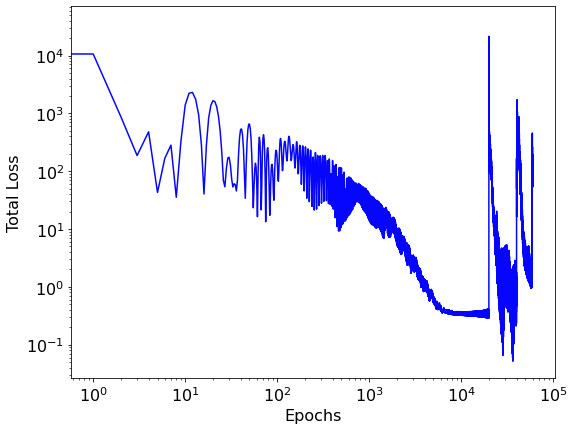

In [11]:
# Loss function
print('Training time (minutes):', runTime1/60)
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[0],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Total Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_total_loss.png', bbox_inches = 'tight')

# Regularization: 1, 1 with boundary at 60, l = 0, force feed n = 1, var_loss

In [12]:
# TEST THE PREDICTED SOLUTIONS
nTest = n_train; tTest = torch.linspace(t0-.1,tf+.1,nTest)
tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi =parametricSolutions(tTest,model1.cpu(),t0,xBC1, tf) 
psi=psi.data.numpy(); 

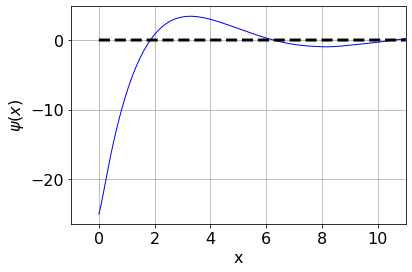

In [13]:
tru = np.sin(3*np.pi*t_net)*np.max(-1*psi)
#plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')
plt.xlim(-1,11)
plt.plot(t_net, 1*psi, '-b', linewidth=1, label = 'ANN')
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')

plotxs = np.linspace(-6,6,100)
L = 2
#plotys = 10*(np.heaviside(plotxs+4/8, 0) + np.heaviside(-1*plotxs+4/8, 0) + np.heaviside(plotxs-20/8, 0) + np.heaviside(-1*plotxs-20/8, 0))-10
#plt.plot(plotxs, plotys, '-r')



Text(0.5, 24.3, 'Epochs')

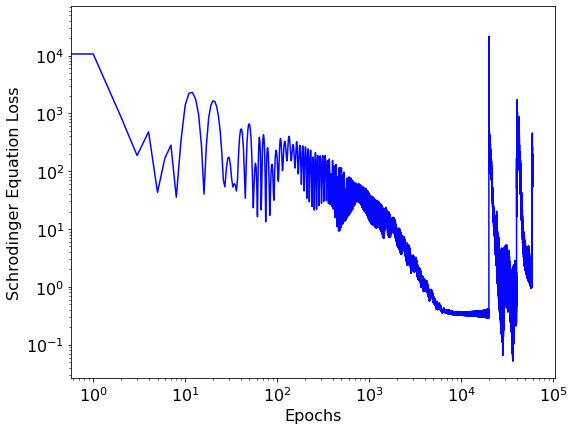

In [14]:
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[3],'-b',alpha=0.975);

plt.tight_layout()
plt.ylabel('Schrodinger Equation Loss');plt.xlabel('Epochs')



In [15]:
#plt.figure(figsize =(8,6))

#plt.loglog(loss_hists1[12],'-b',alpha=0.975);

#plt.tight_layout()
#plt.ylabel('Var Loss');plt.xlabel('Epochs')



Text(0.5, 24.3, 'Epochs')

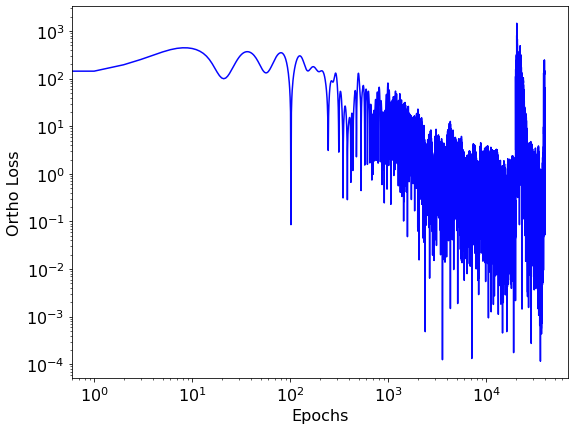

In [16]:
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[11],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Ortho Loss');plt.xlabel('Epochs')

Text(0.5, 24.3, 'Epochs')

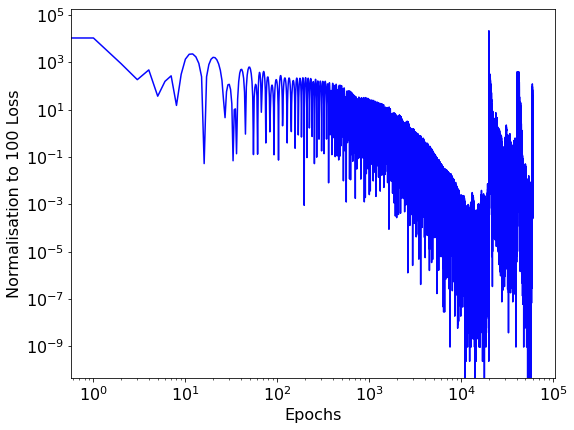

In [17]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[2],'-b',alpha=0.975);

plt.tight_layout()
plt.ylabel('Normalisation to 100 Loss');plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

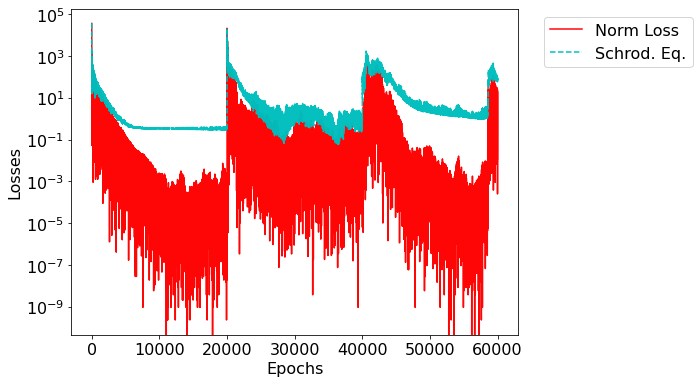

In [18]:
# COMPOUND LOSS PLOT
plt.figure(figsize =(8,6))

plt.semilogy(loss_hists1[2],'-r',alpha=0.975, label = 'Norm Loss');
plt.semilogy(loss_hists1[3],'--c',alpha=0.975, label = 'Schrod. Eq.');
#plt.semilogy(np.add(loss_hists1[2], np.add(loss_hists1[5],loss_hists1[3])),'-k',alpha=0.975, label = 'Total');
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Losses'); plt.xlabel('Epochs')


Text(0.5, 28.0, 'Epochs')

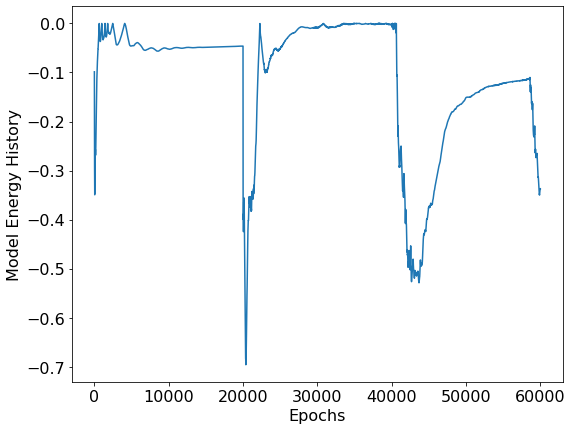

In [19]:
plt.figure(figsize = (8,6))
plt.plot(loss_hists1[8])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Model Energy History');plt.xlabel('Epochs')


Text(0.5, 10.0, 'Epochs')

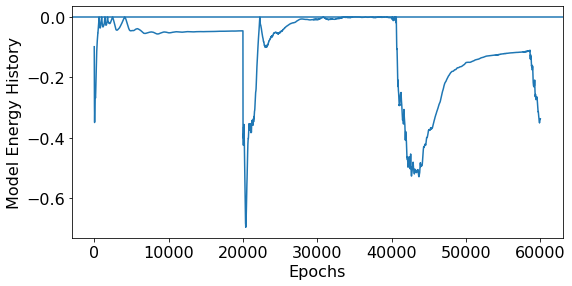

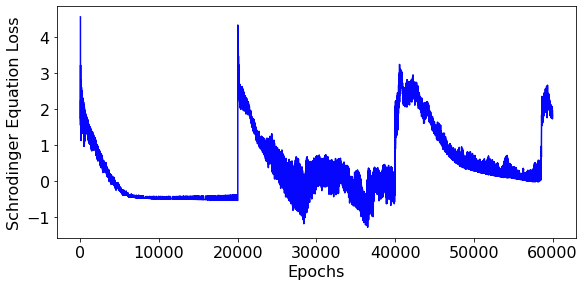

In [20]:
plt.figure(figsize = (8,4))
plt.plot(loss_hists1[8])
plt.axhline(y = 0)
plt.tight_layout()
plt.ylabel('Model Energy History');plt.xlabel('Epochs')

plt.figure(figsize =(8,4))
plt.plot(np.log10(np.asarray(loss_hists1[3])),'-b',alpha=0.975);
plt.tight_layout()
plt.ylabel('Schrodinger Equation Loss');plt.xlabel('Epochs')

In [28]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')
imgdir = '/content/gdrive/My Drive/'

with open(imgdir+'l0_0.05.pickle', 'wb') as handle:
    pickle.dump((model1,loss_hists1,runTime1, first_exc, fc_ground), handle)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


tensor([-0.0004], grad_fn=<SelectBackward>)


Text(0.5, 0, 'x')

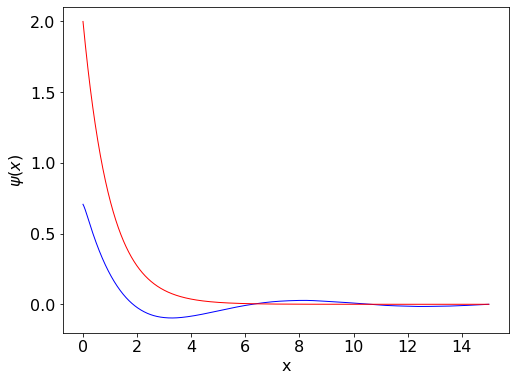

In [22]:
tTest = torch.linspace(0,15,3000).reshape((-1,1))
bin = 13
#loss_hists1[10][bin][0]
tTestnp = tTest.detach().numpy()
const_a = 1
psi_0to10 = parametricSolutions(tTest,model1.cpu(),t0,xBC1, tf)
print(model1(tTest)[1][0])

sol1 = 1/np.sqrt(2)*const_a**(-3/2)*(1-tTestnp/2/const_a)*np.exp(-tTestnp/2/const_a)

plt.figure(figsize = (8,6))
plt.plot(tTestnp, -1*psi_0to10.data.numpy()*max(sol1)/max(-1*psi_0to10.data.numpy()), '-b', linewidth=1, label = 'n = 3')#
plt.plot(tTestnp, 2*const_a**(-3/2)*np.exp(-tTestnp/const_a), '-r', linewidth=1, label = 'n = 1, l = 0')
#plt.plot(tTestnp, 1/np.sqrt(2)*const_a**(-3/2)*(1-tTestnp/2/const_a)*np.exp(-tTestnp/2/const_a), '-r', linewidth=1, label = 'n = 2, l = 0')
#plt.plot(tTestnp, 2/3/np.sqrt(3)*const_a**(-3/2)*(1-2*tTestnp/3/const_a+2/27*(tTestnp/const_a)**2)*np.exp(-tTestnp/3/const_a), '-r', linewidth=1, label = 'n = 3, l = 0')
#plt.plot(tTestnp, 1/4*const_a**(-3/2)*(1-3*tTestnp/4/const_a+1/8*(tTestnp/const_a)**2-1/192*(tTestnp/const_a)**3)*np.exp(-tTestnp/4/const_a), '-r', linewidth=1, label = 'n = 3, l = 0')

plt.ylabel('$\psi(x)$'); plt.xlabel('x')


235920.39


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


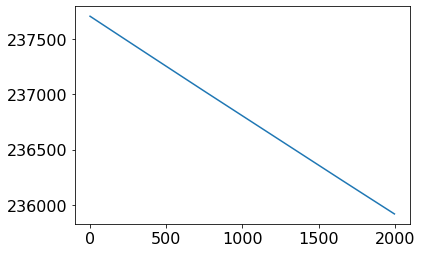

In [23]:
d1 = np.gradient(100*sol1.reshape((1,-1))[0], 0.02)
d2 = np.gradient(d1, 0.02)
V = potential(tTest).detach().numpy()

collect = []
for i in range(1,2000):
  f = d2 + d1*2/tTestnp.reshape((1,-1))[0] + (2*-i/10000+V.reshape((1,-1))[0])*100*sol1.reshape((1,-1))[0]
  L  = (np.square(f[1:])).mean(); 
  collect.append(L)

print(L)
plt.plot(collect)

In [24]:
collect.index(min(collect))

1998

In [25]:
psi_0to10[0]

tensor([-24.9796], grad_fn=<SelectBackward>)

In [26]:
torch.sqrt(torch.dot(psi_0to10[:,0], psi_0to10[:,0]))

tensor(249.6537, grad_fn=<SqrtBackward>)

tensor([-0.0004], grad_fn=<SelectBackward>)


Text(0.5, 0, 'x')

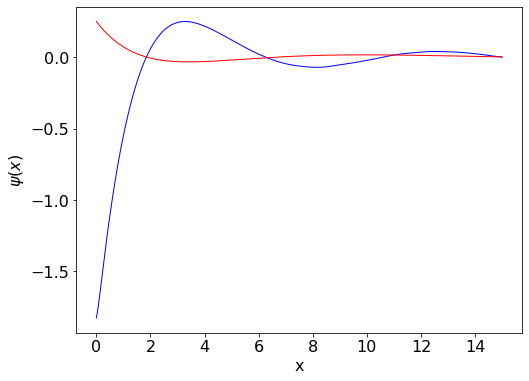

In [27]:
tTest = torch.linspace(0,15,3000).reshape((-1,1))
bin = 1
#loss_hists1[10][bin][0]
tTestnp = tTest.detach().numpy()
const_a = 1
psi_0to10 = parametricSolutions(tTest,model1.cpu(),t0,xBC1, tf)
print(model1(tTest)[1][0])

sol1 = 1/4*const_a**(-3/2)*(1-3*tTestnp/4/const_a+1/8*(tTestnp/const_a)**2-1/192*(tTestnp/const_a)**3)*np.exp(-tTestnp/4/const_a)

plt.figure(figsize = (8,6))
plt.plot(tTestnp, 1*psi_0to10.data.numpy()*max(sol1)/max(1*psi_0to10.data.numpy()), '-b', linewidth=1, label = 'n = 3')#
#plt.plot(tTestnp, 2*const_a**(-3/2)*np.exp(-tTestnp/const_a), '-r', linewidth=1, label = 'n = 1, l = 0')
#plt.plot(tTestnp, 1/np.sqrt(2)*const_a**(-3/2)*(1-tTestnp/2/const_a)*np.exp(-tTestnp/2/const_a), '-r', linewidth=1, label = 'n = 2, l = 0')
#plt.plot(tTestnp, 2/3/np.sqrt(3)*const_a**(-3/2)*(1-2*tTestnp/3/const_a+2/27*(tTestnp/const_a)**2)*np.exp(-tTestnp/3/const_a), '-r', linewidth=1, label = 'n = 3, l = 0')
plt.plot(tTestnp, 1/4*const_a**(-3/2)*(1-3*tTestnp/4/const_a+1/8*(tTestnp/const_a)**2-1/192*(tTestnp/const_a)**3)*np.exp(-tTestnp/4/const_a), '-r', linewidth=1, label = 'n = 3, l = 0')

plt.ylabel('$\psi(x)$'); plt.xlabel('x')
